In [1]:
#Depthwise separable hourglass
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm
from visdom import Visdom
from torch import nn



__all__ = ['HourglassNet', 'hg']


class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=True)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dw_conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, groups=planes, bias=True)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 2, kernel_size=1, bias=True)
        self.elu = nn.ELU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.elu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.elu(out)
        out = self.dw_conv2(out)

        out = self.bn3(out)
        out = self.elu(out)      #Remove if needed
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out


class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, spatial_kernel_size=7):
        super(CBAM, self).__init__()
        self.channels = channels
        self.reduction_ratio = reduction_ratio
        self.spatial_kernel_size = spatial_kernel_size

        # Channel Attention Module
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

        # Spatial Attention Module
        self.conv = nn.Conv2d(2, 1, kernel_size=spatial_kernel_size, padding=spatial_kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel attention
        max_out = self.max_pool(x)
        avg_out = self.avg_pool(x)
        max_out = max_out.view(max_out.size(0), -1)
        avg_out = avg_out.view(avg_out.size(0), -1)
        out = self.fc(max_out) + self.fc(avg_out)
        out = out.view(x.size(0), self.channels, 1, 1)
        channel_att = x * out.expand_as(x)

        # Spatial attention
        max_out = torch.max(channel_att, 1, keepdim=True)[0]
        avg_out = torch.mean(channel_att, 1, keepdim=True)
        out = torch.cat([max_out, avg_out], dim=1)
        out = self.conv(out)
        spatial_att = self.sigmoid(out)
        final = channel_att * spatial_att.expand_as(channel_att)

        return final



class Hourglass(nn.Module):
    def __init__(self, block, num_blocks, planes, depth):
        super(Hourglass, self).__init__()
        self.depth = depth
        self.block = block
        self.hg = self._make_hour_glass(block, num_blocks, planes, depth)
        # Initialize CBAM module, adjusted to the feature depth at the hourglass levels
        self.cbam = CBAM(planes*block.expansion)  # Adjusted planes according to the expansion at block outputs

    def _make_residual(self, block, num_blocks, planes):
        layers = []
        for i in range(0, num_blocks):
            layers.append(block(planes*block.expansion, planes))
        return nn.Sequential(*layers)

    def _make_hour_glass(self, block, num_blocks, planes, depth):
        hg = []
        for i in range(depth):
            res = []
            for j in range(3):
                res.append(self._make_residual(block, num_blocks, planes))
            if i == 0:
                res.append(self._make_residual(block, num_blocks, planes))
            hg.append(nn.ModuleList(res))
        return nn.ModuleList(hg)

    def _hour_glass_forward(self, n, x):
        up1 = self.hg[n-1][0](x)

        low1 = F.max_pool2d(x, 2, stride=2)
        low1 = self.hg[n-1][1](low1)

        if n > 1:
            low2 = self._hour_glass_forward(n-1, low1)
        else:
            low2 = self.hg[n-1][3](low1)
            low2 = self.cbam(low2)


        low3 = self.hg[n-1][2](low2)
        up2 = F.interpolate(low3, scale_factor=2)
        

        out = up1 + up2
        # out = self.cbam(out)
        return out

    def forward(self, x):
        return self._hour_glass_forward(self.depth, x)


class HourglassNet(nn.Module):
    '''Hourglass model from Newell et al ECCV 2016'''

    def __init__(self, block, num_stacks=2, num_blocks=4, num_classes=16):
        super(HourglassNet, self).__init__()

        self.inplanes = 64
        self.num_feats = 128
        self.num_stacks = num_stacks
        self.cbams = nn.ModuleList([CBAM(self.num_feats * block.expansion) for _ in range(num_stacks)])
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=True)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.elu = nn.ELU(inplace=True)
        self.layer1 = self._make_residual(block, self.inplanes, 1)
        self.layer2 = self._make_residual(block, self.inplanes, 1)
        self.layer3 = self._make_residual(block, self.num_feats, 1)
        self.maxpool = nn.MaxPool2d(2, stride=2)

        # build hourglass modules
        ch = self.num_feats*block.expansion
        hg, res, fc, score, fc_, score_ = [], [], [], [], [], []
        for i in range(num_stacks):
            hg.append(Hourglass(block, num_blocks, self.num_feats, 4))
            res.append(self._make_residual(block, self.num_feats, num_blocks))
            fc.append(self._make_fc(ch, ch))
            score.append(nn.Conv2d(ch, num_classes, kernel_size=1, bias=True))
            if i < num_stacks-1:
                fc_.append(nn.Conv2d(ch, ch, kernel_size=1, bias=True))
                score_.append(nn.Conv2d(num_classes, ch,
                              kernel_size=1, bias=True))
        self.hg = nn.ModuleList(hg)
        self.res = nn.ModuleList(res)
        self.fc = nn.ModuleList(fc)
        self.score = nn.ModuleList(score)
        self.fc_ = nn.ModuleList(fc_)
        self.score_ = nn.ModuleList(score_)

    def _make_residual(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=True),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_fc(self, inplanes, outplanes):
        bn = nn.BatchNorm2d(inplanes)
        conv = nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=True)
        return nn.Sequential(
            conv,
            bn,
            self.elu,
        )

    def forward(self, x):
        out = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu(x)

        x = self.layer1(x)
        x = self.maxpool(x)
        x = self.layer2(x)
        x = self.layer3(x)

        for i in range(self.num_stacks):
            y = self.hg[i](x)
            y = self.res[i](y)
            y = self.fc[i](y)
            y = self.cbams[i](y)
            score = self.score[i](y)
            out.append(score)
            if i < self.num_stacks-1:
                fc_ = self.fc_[i](y)
                score_ = self.score_[i](score)
                x = x + fc_ + score_

        return out


def hg_stack2():
    return HourglassNet(Bottleneck,
                         num_stacks=2,
                         num_blocks=1,
                         num_classes=16)

if __name__ == '__main__':
    import torch

    model = hg_stack2()
    x = torch.randn(1,3,256,256)
    print(model(x)[0].size())
    print(model(x)[1].size())


torch.Size([1, 16, 64, 64])
torch.Size([1, 16, 64, 64])


In [2]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
HourglassNet                                            --
├─ModuleList: 1-1                                       --
│    └─CBAM: 2-1                                        --
│    │    └─AdaptiveMaxPool2d: 3-1                      --
│    │    └─AdaptiveAvgPool2d: 3-2                      --
│    │    └─Sequential: 3-3                             8,192
│    │    └─Conv2d: 3-4                                 98
│    │    └─Sigmoid: 3-5                                --
│    └─CBAM: 2-2                                        --
│    │    └─AdaptiveMaxPool2d: 3-6                      --
│    │    └─AdaptiveAvgPool2d: 3-7                      --
│    │    └─Sequential: 3-8                             8,192
│    │    └─Conv2d: 3-9                                 98
│    │    └─Sigmoid: 3-10                               --
├─Conv2d: 1-2                                           9,472
├─BatchNorm2d: 1-3                        

In [3]:
#joints_mse_loss
import torch.nn as nn


class JointsMSELoss(nn.Module):
    def __init__(self, use_target_weight=True):
        super(JointsMSELoss, self).__init__()
        self.criterion = nn.MSELoss(reduction='mean')
        self.use_target_weight = use_target_weight

    def forward(self, output, target, target_weight):
        # output: (b,n_joints,h,w)
        batch_size = output.size(0)
        num_joints = output.size(1)

        # (b,n_joints,h,w) -> (b,n_joints,h*w) -> [(b,1,h*w), ...] There are n_joints elements in total
        heatmaps_pred = output.reshape((batch_size, num_joints, -1)).split(1, 1)
        heatmaps_gt = target.reshape((batch_size, num_joints, -1)).split(1, 1)
        loss = 0

        for idx in range(num_joints):
            # (b,h*w)
            heatmap_pred = heatmaps_pred[idx].squeeze()
            heatmap_gt = heatmaps_gt[idx].squeeze()
            
            if self.use_target_weight:
                loss += 0.5 * self.criterion(
                    heatmap_pred.mul(target_weight[:, idx]),
                    heatmap_gt.mul(target_weight[:, idx])
                )
            else:
                loss += 0.5 * self.criterion(heatmap_pred, heatmap_gt)

        return loss / num_joints


In [4]:
#utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import skimage
import torch
from PIL import Image

joints = [
    'left ankle',
    'left knee',
    'left hip',
    'right hip',
    'right knee',
    'right ankle',
    'belly',
    'chest',
    'neck',
    'head',
    'left wrist',
    'left elbow',
    'left shoulder',
    'right shoulder',
    'right elbow',
    'right wrist'
]


def generate_heatmap(heatmap, pt, sigma=(33, 33), sigma_valu=7):
    '''
    :param heatmap: should be a np zeros array with shape (H,W) (only i channel), not (H,W,1)
    :param pt: point coords, np array
    :param sigma: should be a tuple with odd values (obsolete)
    :param sigma_valu: vaalue for gaussian blur
    :return: a np array of one joint heatmap with shape (H,W)

    This function is obsolete, use 'generate_heatmaps()' instead.
    '''
    heatmap[int(pt[1])][int(pt[0])] = 1
    # heatmap = cv2.GaussianBlur(heatmap, sigma, 0)  #(H,W,1) -> (H,W)
    heatmap = skimage.filters.gaussian(
        heatmap, sigma=sigma_valu)  # (H,W,1) -> (H,W)
    am = np.amax(heatmap)
    heatmap = heatmap/am
    return heatmap


def generate_heatmaps(img, pts, sigma=(33, 33), sigma_valu=7):
    '''
    :param img: np arrray img, (H,W,C)
    :param pts: joint points coords, np array, same resolu as img
    :param sigma: should be a tuple with odd values (obsolete)
    :param sigma_valu: vaalue for gaussian blur
    :return: np array heatmaps, (H,W,num_pts)
    '''
    H, W = img.shape[0], img.shape[1]
    num_pts = pts.shape[0]
    heatmaps = np.zeros((H, W, num_pts))
    for i, pt in enumerate(pts):
        # Filter unavailable heatmaps
        if pt[0] == 0 and pt[1] == 0:
            continue
        # Filter some points out of the image
        if pt[0] >= W:
            pt[0] = W-1
        if pt[1] >= H:
            pt[1] = H-1
        heatmap = heatmaps[:, :, i]
        heatmap[int(pt[1])][int(pt[0])] = 1
        # heatmap = cv2.GaussianBlur(heatmap, sigma, 0)  #(H,W,1) -> (H,W)
        heatmap = skimage.filters.gaussian(
            heatmap, sigma=sigma_valu)  # (H,W,1) -> (H,W)
        am = np.amax(heatmap)
        heatmap = heatmap / am
        heatmaps[:, :, i] = heatmap
    return heatmaps


def load_image(path_image):
    img = mpimg.imread(path_image)
    # Return a np array (H,W,C)
    return img


def crop(img, ele_anno, use_randscale=True, use_randflipLR=False, use_randcolor=False):
    '''
    :param img: np array of the origin image, (H,W,C)
    :param ele_anno: one element of json annotation
    :return: img_crop, ary_pts_crop, c_crop after cropping
    '''

    H, W = img.shape[0], img.shape[1]
    s = ele_anno['scale_provided']
    c = ele_anno['objpos']

    # Adjust center and scale
    if c[0] != -1:
        c[1] = c[1] + 15 * s
        s = s * 1.25
    ary_pts = np.array(ele_anno['joint_self'])  # (16, 3)
    ary_pts_temp = ary_pts[np.any(ary_pts != [0, 0, 0], axis=1)]

    if use_randscale:
        scale_rand = np.random.uniform(low=1.0, high=3.0)
    else:
        scale_rand = 1

    W_min = max(np.amin(ary_pts_temp, axis=0)[0] - s * 15 * scale_rand, 0)
    H_min = max(np.amin(ary_pts_temp, axis=0)[1] - s * 15 * scale_rand, 0)
    W_max = min(np.amax(ary_pts_temp, axis=0)[0] + s * 15 * scale_rand, W)
    H_max = min(np.amax(ary_pts_temp, axis=0)[1] + s * 15 * scale_rand, H)
    W_len = W_max - W_min
    H_len = H_max - H_min
    window_len = max(H_len, W_len)
    pad_updown = (window_len - H_len)/2
    pad_leftright = (window_len - W_len)/2

    # Calculate 4 corner position
    W_low = max((W_min - pad_leftright), 0)
    W_high = min((W_max + pad_leftright), W)
    H_low = max((H_min - pad_updown), 0)
    H_high = min((H_max + pad_updown), H)

    # Update joint points and center
    ary_pts_crop = np.where(
        ary_pts == [0, 0, 0], ary_pts, ary_pts - np.array([W_low, H_low, 0]))
    c_crop = c - np.array([W_low, H_low])

    img_crop = img[int(H_low):int(H_high), int(W_low):int(W_high), :]

    # Pad when H, W different
    H_new, W_new = img_crop.shape[0], img_crop.shape[1]
    window_len_new = max(H_new, W_new)
    pad_updown_new = int((window_len_new - H_new)/2)
    pad_leftright_new = int((window_len_new - W_new)/2)

    # ReUpdate joint points and center (because of the padding)
    ary_pts_crop = np.where(ary_pts_crop == [
                            0, 0, 0], ary_pts_crop, ary_pts_crop + np.array([pad_leftright_new, pad_updown_new, 0]))
    c_crop = c_crop + np.array([pad_leftright_new, pad_updown_new])

    img_crop = cv2.copyMakeBorder(img_crop, pad_updown_new, pad_updown_new,
                                  pad_leftright_new, pad_leftright_new, cv2.BORDER_CONSTANT, value=0)

    # change dtype and num scale
    img_crop = img_crop / 255.
    img_crop = img_crop.astype(np.float64)

    if use_randflipLR:
        flip = np.random.random() > 0.5
        # print('rand_flipLR', flip)
        if flip:
            # (H,W,C)
            img_crop = np.flip(img_crop, 1)
            # Calculate flip pts, remember to filter [0,0] which is no available heatmap
            ary_pts_crop = np.where(ary_pts_crop == [0, 0, 0], ary_pts_crop,
                                    [window_len_new, 0, 0] + ary_pts_crop * [-1, 1, 0])
            c_crop = [window_len_new, 0] + c_crop * [-1, 1]
            # Rearrange pts
            ary_pts_crop = np.concatenate(
                (ary_pts_crop[5::-1], ary_pts_crop[6:10], ary_pts_crop[15:9:-1]))

    if use_randcolor:
        randcolor = np.random.random() > 0.5
        # print('rand_color', randcolor)
        if randcolor:
            img_crop[...,
                     0] *= np.clip(np.random.uniform(low=0.8, high=1.2), 0., 1.)
            img_crop[...,
                     1] *= np.clip(np.random.uniform(low=0.8, high=1.2), 0., 1.)
            img_crop[...,
                     2] *= np.clip(np.random.uniform(low=0.8, high=1.2), 0., 1.)

    return img_crop, ary_pts_crop, c_crop


def change_resolu(img, pts, c, resolu_out=(256, 256)):
    '''
    :param img: np array of the origin image
    :param pts: joint points np array corresponding to the image, same resolu as img
    :param c: center
    :param resolu_out: a list or tuple
    :return: img_out, pts_out, c_out under resolu_out
    '''
    H_in = img.shape[0]
    W_in = img.shape[1]
    H_out = resolu_out[0]
    W_out = resolu_out[1]
    H_scale = H_in/H_out
    W_scale = W_in/W_out

    pts_out = pts/np.array([W_scale, H_scale, 1])
    c_out = c/np.array([W_scale, H_scale])
    img_out = skimage.transform.resize(img, tuple(resolu_out))

    return img_out, pts_out, c_out


def heatmaps_to_coords(heatmaps, resolu_out=[64, 64], prob_threshold=0.2):
    '''
    :param heatmaps: tensor with shape (64,64,16)
    :param resolu_out: output resolution list
    :return coord_joints: np array, shape (16,2)
    '''

    num_joints = heatmaps.shape[2]
    # Resize
    heatmaps = skimage.transform.resize(heatmaps, tuple(resolu_out))

    coord_joints = np.zeros((num_joints, 3))
    for i in range(num_joints):
        heatmap = heatmaps[..., i]
        max = np.max(heatmap)
        # Only keep points larger than a threshold
        if max >= prob_threshold:
            idx = np.where(heatmap == max)
            H = idx[0][0]
            W = idx[1][0]
        else:
            H = 0
            W = 0
        coord_joints[i] = [W, H, max]
    return coord_joints


def show_heatmaps(img, heatmaps, c=np.zeros((2)), num_fig=1):
    '''
    :param img: np array (H,W,3)
    :param heatmaps: np array (H,W,num_pts)
    :param c: center, np array (2,)
    '''
    H, W = img.shape[0], img.shape[1]

    if heatmaps.shape[0] != H:
        heatmaps = skimage.transform.resize(heatmaps, (H, W))

    plt.figure(num_fig)
    for i in range(heatmaps.shape[2] + 1):
        plt.subplot(4, 5, i + 1)
        if i == 0:
            plt.title('Origin')
        else:
            plt.title(joints[i-1])

        if i == 0:
            plt.imshow(img)
        else:
            plt.imshow(heatmaps[:, :, i - 1])

        plt.axis('off')
    plt.subplot(4, 5, 20)
    plt.axis('off')
    plt.show()


def heatmap2rgb(heatmap):
    """
    : heatmap: (h,w)
    """

    heatmap = heatmap.detach().cpu().numpy()

    # plt.figure(figsize=(1,1))
    # plt.axis('off')
    # plt.imshow(heatmap)
    # plt.savefig('tmp/tmp.jpg', bbox_inches='tight', pad_inches=0, dpi=70)
    # plt.close()
    # plt.clf()

    # img = Image.open('tmp/tmp.jpg')
    cm = plt.get_cmap('jet')
    normed_data = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap + 1e-8))
    mapped_data = cm(normed_data)

    # (h,w,c)
    # img = np.array(img)
    img = np.array(mapped_data)
    img = img[:,:,:3]
    img = torch.tensor(img).permute(2, 0, 1)
    
    return img


def heatmaps2rgb(heatmaps):
    """
    : heatmaps: (b,h,w)
    """

    out_imgs = []
    for heatmap in heatmaps:
        out_imgs.append(heatmap2rgb(heatmap))

    return torch.stack(out_imgs)


def draw_joints(img, pts):
    scores = pts[:,2]
    pts = np.array(pts).astype(int)

    for i in range(pts.shape[0]):
        if pts[i, 0] != 0 and pts[i, 1] != 0:
            img = cv2.circle(img, (pts[i, 0], pts[i, 1]), radius=5,
                             color=(255, 0, 0), thickness=-1)
            # img = cv2.putText(img, f'{joints[i]}: {scores[i]:.2f}', (
            #     pts[i, 0]+5, pts[i, 1]-5), cv2.FONT_HERSHEY_SIMPLEX, .35, (255, 0, 0))

    # Left arm
    for i in range(10, 13-1):
        if pts[i, 0] != 0 and pts[i, 1] != 0 and pts[i+1, 0] != 0 and pts[i+1, 1] != 0:
            img = cv2.line(img, (pts[i, 0], pts[i, 1]), (pts[i+1, 0],
                           pts[i+1, 1]), color=(255, 0, 0), thickness=1)

    # Right arm
    for i in range(13, 16-1):
        if pts[i, 0] != 0 and pts[i, 1] != 0 and pts[i+1, 0] != 0 and pts[i+1, 1] != 0:
            img = cv2.line(img, (pts[i, 0], pts[i, 1]), (pts[i+1, 0],
                           pts[i+1, 1]), color=(255, 0, 0), thickness=1)

    # Left leg
    for i in range(0, 3-1):
        if pts[i, 0] != 0 and pts[i, 1] != 0 and pts[i+1, 0] != 0 and pts[i+1, 1] != 0:
            img = cv2.line(img, (pts[i, 0], pts[i, 1]), (pts[i+1, 0],
                           pts[i+1, 1]), color=(255, 0, 0), thickness=1)
    # Right leg
    for i in range(3, 6-1):
        if pts[i, 0] != 0 and pts[i, 1] != 0 and pts[i+1, 0] != 0 and pts[i+1, 1] != 0:
            img = cv2.line(img, (pts[i, 0], pts[i, 1]), (pts[i+1, 0],
                           pts[i+1, 1]), color=(255, 0, 0), thickness=1)

    # Body
    for i in range(6, 10-1):
        if pts[i, 0] != 0 and pts[i, 1] != 0 and pts[i+1, 0] != 0 and pts[i+1, 1] != 0:
            img = cv2.line(img, (pts[i, 0], pts[i, 1]), (pts[i+1, 0],
                           pts[i+1, 1]), color=(255, 0, 0), thickness=1)

    if pts[2, 0] != 0 and pts[2, 1] != 0 and pts[3, 0] != 0 and pts[3, 1] != 0:
        img = cv2.line(img, (pts[2, 0], pts[2, 1]), (pts[2+1, 0],
                       pts[2+1, 1]), color=(255, 0, 0), thickness=1)
    if pts[12, 0] != 0 and pts[12, 1] != 0 and pts[13, 0] != 0 and pts[13, 1] != 0:
        img = cv2.line(img, (pts[12, 0], pts[12, 1]), (pts[12+1, 0],
                       pts[12+1, 1]), color=(255, 0, 0), thickness=1)

    return img


In [5]:
#mpii_dataset
import numpy as np
from torch.utils.data import Dataset
import skimage
import json

# from utils import load_image, crop, change_resolu, generate_heatmaps

import os

class MPIIDataset(Dataset):
    def __init__(self, is_train=True, use_scale=True, use_flip=True, use_rand_color=True):
        self.is_trian = is_train
        self.use_scale = use_scale
        self.use_flip = use_flip
        self.use_rand_color = use_rand_color
        
        # Get json annotation
        with open('/srv/scratch/z5512000/data/originalmpii_annotations.json') as anno_file:
            self.anno = json.load(anno_file)  # len 25204
#Classifying Annotations: During the initialization of your dataset instance, 
#it iterates through each annotation and categorizes them into either train_list or valid_list based on the isValidation flag:
        self.train_list, self.valid_list = [], []  # 22246, 2958
        for idex, ele_anno in enumerate(self.anno):
            if ele_anno['isValidation'] == True:
                self.valid_list.append(idex)
            else:
                self.train_list.append(idex)
        print("Length of train list:", len(self.train_list))
        print("Length of validation list:", len(self.valid_list))

    def __getitem__(self, idx):
        if self.is_trian:
            ele_anno = self.anno[self.train_list[idx]]
        else:
            ele_anno = self.anno[self.valid_list[idx]]
        res_img = [256, 256]
        res_heatmap = [64, 64]
        # path_img_folder = '/srv/scratch/z5512000/data/mpii_human_pose_v1/images'
        path_img_folder = '/srv/scratch/z5512000/data/mpiiimages'
        path_img = os.path.join(path_img_folder, ele_anno['img_paths'])
        img_origin = load_image(path_img)

        img_crop, ary_pts_crop, c_crop = crop(img_origin, ele_anno, use_randscale=self.use_scale,
                                                        use_randflipLR=self.use_flip, use_randcolor=self.use_rand_color)

        img_out, pts_out, _ = change_resolu(img_crop, ary_pts_crop, c_crop, res_heatmap)

        processed_img = skimage.transform.resize(img_crop, tuple(res_img))
        output_heatmap = generate_heatmaps(img_out, pts_out, sigma_valu=2)
        out_pts = pts_out[:, :2].astype(np.int32)

        # (H,W,C) -> (C,H,W)
        processed_img = np.transpose(processed_img, (2, 0, 1))
        output_heatmap = np.transpose(output_heatmap, (2, 0, 1))

        return processed_img, output_heatmap, out_pts

    def __len__(self):
        if self.is_trian:
            return len(self.train_list)
        else:
            return len(self.valid_list)

if __name__ == '__main__':
    dataset = MPIIDataset()
    img, heatmap, pts = dataset[0]
    print(img.shape) # (3,256,256)
    print(heatmap.shape) # (16,64,64)
    print(pts.shape) # (16,2)

Length of train list: 22246
Length of validation list: 2958
(3, 256, 256)
(16, 64, 64)
(16, 2)


In [6]:
from torch.utils.data import DataLoader
bs = 8
# Create the dataset instances
train_dataset = MPIIDataset(is_train=True, use_scale=True, use_flip=True, use_rand_color=True)
validation_dataset = MPIIDataset(is_train=False, use_scale=False, use_flip=False, use_rand_color=False)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=6, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=6)


Length of train list: 22246
Length of validation list: 2958
Length of train list: 22246
Length of validation list: 2958


In [6]:
# Start visdom for visualizations during training
# python -m visdom.server

In [6]:
def calculate_accuracy(heatmaps_pred, heatmaps_gt, threshold=0.5):
    """
    Calculate accuracy by comparing the predicted heatmaps to the ground truth heatmaps.
    """
    pred_flat = (heatmaps_pred >= threshold).float().view(-1)
    gt_flat = (heatmaps_gt >= threshold).float().view(-1)
    
    correct_predictions = (pred_flat == gt_flat).float().sum()
    accuracy = correct_predictions / gt_flat.size(0)
    
    return accuracy.item()

In [8]:
#train.py


from torch.optim.lr_scheduler import ReduceLROnPlateau

seed = 999
use_model = 'Hourglass_Stack2' # Options：Hourglass_Stack2, ResNet, HRNet
lr = 2.5e-4
bs = 8
##Dont forget to change if continuing training. if starting from 100th epoch code wont work 
#because n_epochs is already 100, so to train for next 100 epochs set n_epochs as 200
#then training will start from 100 till 200.
n_epoches = 40
ckpt = '/srv/scratch/z5512000/weights/full/pdwhourglassepoch23.pth' #Historical model file, Comment this if this is first training.
# ckpt = None   #comment this if using checkpoints for training.

print(f'Use Model: {use_model}')
if ckpt:
    print(f'Load ckpt {ckpt}')

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda:0')

model = hg_stack2().to(device)


optimizer = Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)
criteon = JointsMSELoss().to(device)

# epoch_losses = []
# ep_start = 1  # Initialize default starting epoch
# Check if checkpoint exists and load it
if ckpt:
    checkpoint = torch.load(ckpt)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optim'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    epoch_losses = checkpoint.get('epoch_losses', []) #to store loss
    ep_start = checkpoint['epoch'] + 1
else:
    epoch_losses = []  # No checkpoint exists, start with an empty list
    ep_start = 1       # Start from the first epoch

target_weight = np.array([[1.2, 1.1, 1., 1., 1.1, 1.2, 1., 1.,
                           1., 1., 1.2, 1.1, 1., 1., 1.1, 1.2]])
target_weight = torch.from_numpy(target_weight).to(device).float()

viz = Visdom()
viz.line([0], [0], win='Train Loss', opts=dict(title='Train Loss'))
start_time = time.time()
for ep in range(ep_start, n_epoches+1):
    model.train()
    total_loss, count = 0., 0
    periodic_loss, periodic_count = 0., 0

    for index, (img, heatmaps, pts) in enumerate(tqdm(train_loader, desc=f'Epoch{ep}')):
        img, heatmaps = img.to(device).float(), heatmaps.to(device).float()

        heatmaps_preds = model(img)
        heatmaps_pred = heatmaps_preds[-1]
           # relay supervision
        loss1 = criteon(heatmaps_preds[0], heatmaps, target_weight)
        loss2 = criteon(heatmaps_preds[1], heatmaps, target_weight)
        loss = (loss1 + loss2) / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cur_step = (ep-1) * len(train_loader) + index
        total_loss += loss.item()
        count += 1
        periodic_loss += loss.item()
        periodic_count += 1
        if periodic_count == 10 or index == len(train_loader) - 1:
            viz.line([periodic_loss / periodic_count], [cur_step], win='Train Loss', update='append')
            viz.image(img[0], win='Image', opts=dict(title='Image'))
            viz.images(heatmaps2rgb(heatmaps[0]), nrow=4, win=f'GT Heatmaps', opts=dict(title=f'GT Heatmaps'))
            viz.images(heatmaps2rgb(heatmaps_pred[0]), nrow=4, win=f'Pred Heatmaps', opts=dict(title=f'Pred Heatmaps'))
            
            # final_loss = total_loss / count
            periodic_loss, periodic_count = 0., 0 
    final_loss = total_loss / count
    epoch_losses.append(final_loss)
    lr_scheduler.step(final_loss) #confusion
    print(f'Epoch {ep}: Average Loss: {final_loss:.10f}') 
    torch.save({
        'epoch': ep,
        'model': model.state_dict(),
        'optim': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch_losses': epoch_losses  # Update losses in the checkpoint
    }, f'/srv/scratch/z5512000/weights/full/pdwhourglassepoch{ep}.pth')
    torch.cuda.empty_cache()
training_duration = time.time() - start_time
# Plotting the training loss after training completes
print(f'Total training time: {training_duration:.2f} seconds')

Use Model: Hourglass_Stack2
Load ckpt /srv/scratch/z5512000/weights/full/pdwhourglassepoch23.pth


/home/z5512000/.venvs/activityo/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Setting up a new session...
Epoch24: 100%|██████████████████████████████| 2781/2781 [19:18<00:00,  2.40it/s]


Epoch 24: Average Loss: 0.0006683969


Epoch25: 100%|██████████████████████████████| 2781/2781 [11:25<00:00,  4.05it/s]


Epoch 25: Average Loss: 0.0006594567


Epoch26: 100%|██████████████████████████████| 2781/2781 [11:16<00:00,  4.11it/s]


Epoch 26: Average Loss: 0.0006528708


Epoch27: 100%|██████████████████████████████| 2781/2781 [11:20<00:00,  4.09it/s]


Epoch 27: Average Loss: 0.0006461791


Epoch28: 100%|██████████████████████████████| 2781/2781 [11:12<00:00,  4.13it/s]


Epoch 28: Average Loss: 0.0006513774


Epoch29: 100%|██████████████████████████████| 2781/2781 [11:14<00:00,  4.12it/s]


Epoch 29: Average Loss: 0.0006506198


Epoch30: 100%|██████████████████████████████| 2781/2781 [11:24<00:00,  4.06it/s]


Epoch 30: Average Loss: 0.0006464516


Epoch31: 100%|██████████████████████████████| 2781/2781 [11:24<00:00,  4.06it/s]


Epoch 31: Average Loss: 0.0006408335


Epoch32: 100%|██████████████████████████████| 2781/2781 [11:34<00:00,  4.01it/s]


Epoch 32: Average Loss: 0.0006339783


Epoch33: 100%|██████████████████████████████| 2781/2781 [11:26<00:00,  4.05it/s]


Epoch 33: Average Loss: 0.0006465498


Epoch34: 100%|██████████████████████████████| 2781/2781 [11:22<00:00,  4.07it/s]


Epoch 34: Average Loss: 0.0006401642


Epoch35: 100%|██████████████████████████████| 2781/2781 [11:16<00:00,  4.11it/s]


Epoch 35: Average Loss: 0.0006354365


Epoch36: 100%|██████████████████████████████| 2781/2781 [11:27<00:00,  4.05it/s]


Epoch 36: Average Loss: 0.0006312409


Epoch37: 100%|██████████████████████████████| 2781/2781 [11:29<00:00,  4.03it/s]


Epoch 37: Average Loss: 0.0006297883


Epoch38: 100%|██████████████████████████████| 2781/2781 [13:12<00:00,  3.51it/s]


Epoch 38: Average Loss: 0.0006214891


Epoch39: 100%|██████████████████████████████| 2781/2781 [15:05<00:00,  3.07it/s]


Epoch 39: Average Loss: 0.0006171393


Epoch40: 100%|██████████████████████████████| 2781/2781 [11:33<00:00,  4.01it/s]


Epoch 40: Average Loss: 0.0006143154
Total training time: 12449.80 seconds


In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import numpy as np

seed = 999
use_model = 'Hourglass_Stack2'
lr = 2.5e-4
bs = 8
n_epoches = 40
ckpt = '/srv/scratch/z5512000/weights/full/accpdwhourglassepoch28.pth'

print(f'Use Model: {use_model}')
if ckpt:
    print(f'Load ckpt {ckpt}')

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda:0')

model = hg_stack2().to(device)

optimizer = Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)
criteon = JointsMSELoss().to(device)

# Check if checkpoint exists and load it
if ckpt:
    checkpoint = torch.load(ckpt)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optim'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    epoch_losses = checkpoint.get('epoch_losses', [])  # Load previous losses
    epoch_pckhs = checkpoint.get('epoch_pckhs', [])  # Load previous PCKh scores
    ep_start = checkpoint['epoch'] + 1
else:
    epoch_losses = []  # Start with an empty list for losses
    epoch_pckhs = []  # Start with an empty list for PCKh scores
    ep_start = 1  # Start from the first epoch

target_weight = np.array([[1.2, 1.1, 1., 1., 1.1, 1.2, 1., 1.,
                           1., 1., 1.2, 1.1, 1., 1., 1.1, 1.2]])
target_weight = torch.from_numpy(target_weight).to(device).float()

viz = Visdom()
viz.line([0], [0], win='Train Loss', opts=dict(title='Train Loss'))
start_time = time.time()

def calculate_pckh(model, validation_loader, device, threshold_factor=0.5):
    total_count = 0
    correct_count = 0

    model.eval()
    with torch.no_grad():
        for img, heatmaps_gt, gt_coords in validation_loader:
            img = img.to(device).float()
            heatmaps_pred = model(img)[-1].double().detach()

            for i in range(img.shape[0]):
                heatmaps_np = heatmaps_pred[i].permute(1, 2, 0).cpu().numpy()
                predicted_coords = heatmaps_to_coords(heatmaps_np, resolu_out=[256, 256], prob_threshold=0.1)
                gt_coords_single = gt_coords[i].cpu().numpy()

                head_length = np.linalg.norm(gt_coords_single[9] - gt_coords_single[8])
                threshold = threshold_factor * head_length

                for j in range(predicted_coords.shape[0]):
                    dist = np.linalg.norm(predicted_coords[j, :2] - gt_coords_single[j, :2])
                    if dist <= threshold:
                        correct_count += 1
                    total_count += 1

    pckh_score = correct_count / total_count if total_count > 0 else 0

    return pckh_score

for ep in range(ep_start, n_epoches + 1):
    model.train()
    total_loss, count = 0., 0
    periodic_loss, periodic_count = 0., 0

    for index, (img, heatmaps, pts) in enumerate(tqdm(train_loader, desc=f'Epoch{ep}')):
        img, heatmaps = img.to(device).float(), heatmaps.to(device).float()

        heatmaps_preds = model(img)
        heatmaps_pred = heatmaps_preds[-1]

        # Calculate loss
        loss1 = criteon(heatmaps_preds[0], heatmaps, target_weight)
        loss2 = criteon(heatmaps_preds[1], heatmaps, target_weight)
        loss = (loss1 + loss2) / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cur_step = (ep - 1) * len(train_loader) + index
        total_loss += loss.item()
        count += 1
        periodic_loss += loss.item()
        periodic_count += 1

        if periodic_count == 10 or index == len(train_loader) - 1:
            viz.line([periodic_loss / periodic_count], [cur_step], win='Train Loss', update='append')
            viz.image(img[0], win='Image', opts=dict(title='Image'))
            viz.images(heatmaps2rgb(heatmaps[0]), nrow=4, win=f'GT Heatmaps', opts=dict(title=f'GT Heatmaps'))
            viz.images(heatmaps2rgb(heatmaps_pred[0]), nrow=4, win=f'Pred Heatmaps', opts=dict(title=f'Pred Heatmaps'))
            
            periodic_loss, periodic_count = 0., 0 

    final_loss = total_loss / count
    epoch_losses.append(final_loss)

    # Calculate PCKh on validation set
    pckh_score = calculate_pckh(model, validation_loader, device)
    epoch_pckhs.append(pckh_score)
    pckh_score = 10 * pckh_score #it should be 100, forgot to add. so its added in plotting graph step.

    lr_scheduler.step(final_loss)
    print(f'Epoch {ep}: Average Loss: {final_loss:.10f}, PCKh@0.5: {pckh_score:.2f}') 
    
    torch.save({
        'epoch': ep,
        'model': model.state_dict(),
        'optim': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch_losses': epoch_losses,  # Save losses in the checkpoint
        'epoch_pckhs': epoch_pckhs  # Save PCKh scores in the checkpoint
    }, f'/srv/scratch/z5512000/weights/full/accpdwhourglassepoch{ep}.pth')
    torch.cuda.empty_cache()

training_duration = time.time() - start_time
print(f'Total training time: {training_duration:.2f} seconds')


Use Model: Hourglass_Stack2
Load ckpt /srv/scratch/z5512000/weights/full/accpdwhourglassepoch28.pth


Setting up a new session...
Epoch29: 100%|██████████████████████████████| 2781/2781 [11:18<00:00,  4.10it/s]


Epoch 29: Average Loss: 0.0006490273, PCKh@0.5: 0.51


Epoch30: 100%|██████████████████████████████| 2781/2781 [10:14<00:00,  4.53it/s]


Epoch 30: Average Loss: 0.0006459367, PCKh@0.5: 0.52


Epoch31: 100%|██████████████████████████████| 2781/2781 [10:13<00:00,  4.53it/s]


Epoch 31: Average Loss: 0.0006394744, PCKh@0.5: 0.52


Epoch32: 100%|██████████████████████████████| 2781/2781 [10:23<00:00,  4.46it/s]


Epoch 32: Average Loss: 0.0006315587, PCKh@0.5: 0.52


Epoch33: 100%|██████████████████████████████| 2781/2781 [10:31<00:00,  4.40it/s]


Epoch 33: Average Loss: 0.0006285023, PCKh@0.5: 0.52


Epoch34: 100%|██████████████████████████████| 2781/2781 [10:23<00:00,  4.46it/s]


Epoch 34: Average Loss: 0.0006236355, PCKh@0.5: 0.52


Epoch35: 100%|██████████████████████████████| 2781/2781 [10:28<00:00,  4.42it/s]


Epoch 35: Average Loss: 0.0006201797, PCKh@0.5: 0.51


Epoch36: 100%|██████████████████████████████| 2781/2781 [10:18<00:00,  4.49it/s]


Epoch 36: Average Loss: 0.0006136419, PCKh@0.5: 0.52


Epoch37: 100%|██████████████████████████████| 2781/2781 [10:16<00:00,  4.51it/s]


Epoch 37: Average Loss: 0.0006107358, PCKh@0.5: 0.52


Epoch38: 100%|██████████████████████████████| 2781/2781 [10:24<00:00,  4.46it/s]


Epoch 38: Average Loss: 0.0006063051, PCKh@0.5: 0.50


Epoch39: 100%|██████████████████████████████| 2781/2781 [10:19<00:00,  4.49it/s]


Epoch 39: Average Loss: 0.0006042847, PCKh@0.5: 0.54


Epoch40: 100%|██████████████████████████████| 2781/2781 [10:22<00:00,  4.47it/s]


Epoch 40: Average Loss: 0.0005975286, PCKh@0.5: 0.54
Total training time: 9860.41 seconds


In [8]:
#AP from train loader
import numpy as np
from sklearn.metrics import auc
import torch

def calculate_precision_recall(y_true, y_pred, thresholds):
    precision = []
    recall = []
    for threshold in thresholds:
        tp = ((y_pred >= threshold) & (y_true == 1)).sum()
        fp = ((y_pred >= threshold) & (y_true == 0)).sum()
        fn = ((y_pred < threshold) & (y_true == 1)).sum()
        
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        precision.append(prec)
        recall.append(rec)
    return precision, recall

def average_precision(precision, recall):
    # Sort by recall
    sorted_indices = np.argsort(recall)
    sorted_recall = np.array(recall)[sorted_indices]
    sorted_precision = np.array(precision)[sorted_indices]
    
    # Calculate the area under the curve using the trapezoidal rule
    return auc(sorted_recall, sorted_precision)

def calculate_map_on_train(train_loader, model, device):
    model.eval()
    thresholds = np.linspace(0, 1, num=100)
    joint_precisions = [[] for _ in range(16)]  # Initialize lists to hold precision values for each joint
    joint_recalls = [[] for _ in range(16)]  # Initialize lists to hold recall values for each joint
    joints = ['left ankle', 'left knee', 'left hip', 'right hip', 'right knee', 'right ankle', 'belly', 'chest',
              'neck', 'head', 'left wrist', 'left elbow', 'left shoulder', 'right shoulder', 'right elbow', 'right wrist']

    with torch.no_grad():
        for img, heatmaps_gt, _ in train_loader:
            img, heatmaps_gt = img.to(device).float(), heatmaps_gt.to(device).float()
            heatmaps_pred = model(img)[-1]  # Last stack predictions

            for i, joint in enumerate(joints):
                true_heatmap = heatmaps_gt[:, i, :, :].reshape(-1).cpu().numpy()
                pred_heatmap = heatmaps_pred[:, i, :, :].reshape(-1).cpu().numpy()

                precisions, recalls = calculate_precision_recall(true_heatmap, pred_heatmap, thresholds)
                
                # Accumulate precision and recall values across all images for each joint
                joint_precisions[i].extend(precisions)
                joint_recalls[i].extend(recalls)

    # Calculate AP for each joint across all images
    aps = []
    for i, joint in enumerate(joints):
        ap = average_precision(joint_precisions[i], joint_recalls[i])
        ap = ap*100
        aps.append(ap)
        #print(f"AP for {joint}: {ap:.4f}")

    mAP = np.mean(aps)
    #print(f"Average Precision across all joints, AP: {mAP:.4f}")
    # return mAP
    
    # # Plotting the results
    # plt.figure(figsize=(12, 6))
    # plt.bar(joints, aps, color='skyblue')
    # plt.xlabel('Joints')
    # plt.ylabel('Average Precision')
    # plt.title('Average Precision (AP) Across All Joints')
    # plt.xticks(rotation=45, ha='right')
    # plt.ylim(0, 100)  # Assuming AP values are between 0 and 1
    # plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.show()
    
    return mAP



In [10]:
# Training code with AP too.
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import numpy as np
import time

seed = 999
use_model = 'Hourglass_Stack2'
lr = 2.5e-4
bs = 8
n_epoches = 40
ckpt = '/srv/scratch/z5512000/weights/full/appdwhourglassepoch22.pth'

print(f'Use Model: {use_model}')
if ckpt:
    print(f'Load ckpt {ckpt}')

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda:0')

model = hg_stack2().to(device)

optimizer = Adam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)
criteon = JointsMSELoss().to(device)

# Check if checkpoint exists and load it
if ckpt:
    checkpoint = torch.load(ckpt)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optim'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    epoch_losses = checkpoint.get('epoch_losses', [])  # Load previous losses
    # epoch_pckhs = checkpoint.get('epoch_pckhs', [])  # Load previous PCKh scores
    epoch_aps = checkpoint.get('epoch_aps', [])  # Load previous AP scores
    ep_start = checkpoint['epoch'] + 1
else:
    epoch_losses = []  # Start with an empty list for losses
    # epoch_pckhs = []  # Start with an empty list for PCKh scores
    epoch_aps = []  # Start with an empty list for AP scores
    ep_start = 1  # Start from the first epoch

target_weight = np.array([[1.2, 1.1, 1., 1., 1.1, 1.2, 1., 1.,
                           1., 1., 1.2, 1.1, 1., 1., 1.1, 1.2]])
target_weight = torch.from_numpy(target_weight).to(device).float()

viz = Visdom()
viz.line([0], [0], win='Train Loss', opts=dict(title='Train Loss'))
start_time = time.time()

for ep in range(ep_start, n_epoches + 1):
    model.train()
    total_loss, count = 0., 0
    periodic_loss, periodic_count = 0., 0

    for index, (img, heatmaps, pts) in enumerate(tqdm(train_loader, desc=f'Epoch{ep}')):
        img, heatmaps = img.to(device).float(), heatmaps.to(device).float()

        heatmaps_preds = model(img)
        heatmaps_pred = heatmaps_preds[-1]

        # Calculate loss
        loss1 = criteon(heatmaps_preds[0], heatmaps, target_weight)
        loss2 = criteon(heatmaps_preds[1], heatmaps, target_weight)
        loss = (loss1 + loss2) / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cur_step = (ep - 1) * len(train_loader) + index
        total_loss += loss.item()
        count += 1
        periodic_loss += loss.item()
        periodic_count += 1

        if periodic_count == 10 or index == len(train_loader) - 1:
            viz.line([periodic_loss / periodic_count], [cur_step], win='Train Loss', update='append')
            viz.image(img[0], win='Image', opts=dict(title='Image'))
            viz.images(heatmaps2rgb(heatmaps[0]), nrow=4, win=f'GT Heatmaps', opts=dict(title=f'GT Heatmaps'))
            viz.images(heatmaps2rgb(heatmaps_pred[0]), nrow=4, win=f'Pred Heatmaps', opts=dict(title=f'Pred Heatmaps'))
            
            periodic_loss, periodic_count = 0., 0 

    final_loss = total_loss / count
    epoch_losses.append(final_loss)

    # Calculate PCKh on train set
    # pckh_score = calculate_pckh(model, train_loader, device)
    # epoch_pckhs.append(pckh_score)
    # pckh_score = 10 * pckh_score #it should be 100, forgot to add. so its added in plotting graph step.

    ap_score = calculate_map_on_train(train_loader, model, device)
    epoch_aps.append(ap_score)

    lr_scheduler.step(final_loss)
    print(f'Epoch {ep}: Average Loss: {final_loss:.10f}, AP: {ap_score:.4f}') 
    
    torch.save({
        'epoch': ep,
        'model': model.state_dict(),
        'optim': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch_losses': epoch_losses,  # Save losses in the checkpoint
        # 'epoch_pckhs': epoch_pckhs,  # Save PCKh scores in the checkpoint
        'epoch_aps': epoch_aps  # Save AP values in the checkpoint
    }, f'/srv/scratch/z5512000/weights/full/appdwhourglassepoch{ep}.pth')
    torch.cuda.empty_cache()

training_duration = time.time() - start_time
print(f'Total training time: {training_duration:.2f} seconds')


Use Model: Hourglass_Stack2
Load ckpt /srv/scratch/z5512000/weights/full/appdwhourglassepoch22.pth


/home/z5512000/.venvs/activityo/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Setting up a new session...
Epoch23: 100%|██████████████████████████████| 2781/2781 [11:12<00:00,  4.14it/s]


Epoch 23: Average Loss: 0.0006488478, AP: 77.1053


Epoch24: 100%|██████████████████████████████| 2781/2781 [10:08<00:00,  4.57it/s]


Epoch 24: Average Loss: 0.0006384996, AP: 77.8357


Epoch25: 100%|██████████████████████████████| 2781/2781 [10:05<00:00,  4.59it/s]


Epoch 25: Average Loss: 0.0006715967, AP: 75.3571


Epoch26: 100%|██████████████████████████████| 2781/2781 [10:19<00:00,  4.49it/s]


Epoch 26: Average Loss: 0.0006601735, AP: 73.1374


Epoch27: 100%|██████████████████████████████| 2781/2781 [10:17<00:00,  4.51it/s]


Epoch 27: Average Loss: 0.0006525350, AP: 75.6357


Epoch28: 100%|██████████████████████████████| 2781/2781 [10:13<00:00,  4.53it/s]


Epoch 28: Average Loss: 0.0006460707, AP: 75.5726


Epoch29: 100%|██████████████████████████████| 2781/2781 [10:13<00:00,  4.53it/s]


Epoch 29: Average Loss: 0.0006411755, AP: 75.3657


Epoch30: 100%|██████████████████████████████| 2781/2781 [10:31<00:00,  4.41it/s]


Epoch 30: Average Loss: 0.0006346321, AP: 79.2555


Epoch31: 100%|██████████████████████████████| 2781/2781 [10:26<00:00,  4.44it/s]


Epoch 31: Average Loss: 0.0006337395, AP: 76.3216


Epoch32: 100%|██████████████████████████████| 2781/2781 [10:13<00:00,  4.53it/s]


Epoch 32: Average Loss: 0.0006325045, AP: 77.1269


Epoch33: 100%|██████████████████████████████| 2781/2781 [10:32<00:00,  4.40it/s]


Epoch 33: Average Loss: 0.0006371552, AP: 79.3563


Epoch34: 100%|██████████████████████████████| 2781/2781 [10:46<00:00,  4.30it/s]


Epoch 34: Average Loss: 0.0006371667, AP: 77.5153


Epoch35: 100%|██████████████████████████████| 2781/2781 [10:21<00:00,  4.47it/s]


Epoch 35: Average Loss: 0.0006272341, AP: 79.7179


Epoch36: 100%|██████████████████████████████| 2781/2781 [10:19<00:00,  4.49it/s]


Epoch 36: Average Loss: 0.0006249826, AP: 77.9812


Epoch37: 100%|██████████████████████████████| 2781/2781 [11:07<00:00,  4.17it/s]


Epoch 37: Average Loss: 0.0006207595, AP: 75.7943


Epoch38: 100%|██████████████████████████████| 2781/2781 [10:15<00:00,  4.52it/s]


Epoch 38: Average Loss: 0.0006169440, AP: 74.3007


Epoch39: 100%|██████████████████████████████| 2781/2781 [10:27<00:00,  4.43it/s]


Epoch 39: Average Loss: 0.0006112882, AP: 74.6599


Epoch40: 100%|██████████████████████████████| 2781/2781 [10:19<00:00,  4.49it/s]


Epoch 40: Average Loss: 0.0006082912, AP: 78.7355
Total training time: 22901.77 seconds


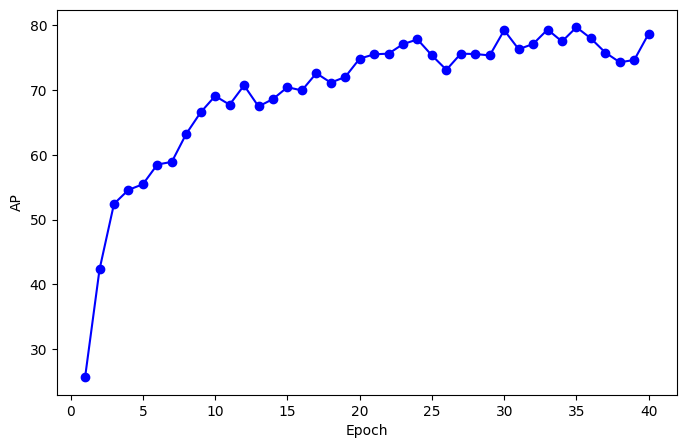

In [7]:
import matplotlib.pyplot as plt

# Load the latest checkpoint
ckpt = '/srv/scratch/z5512000/weights/full/appdwhourglassepoch40.pth'
checkpoint = torch.load(ckpt)
epoch_aps = checkpoint['epoch_aps']

# Multiply each PCKh value by 10
# epoch_pckhs_multiplied = [pckh * 10 for pckh in epoch_pckhs]

# Plot the modified PCKh values
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_aps) + 1), epoch_aps, marker='o', linestyle='-', color='blue')
plt.title('')
plt.xlabel('Epoch')
plt.ylabel('AP')
plt.show()


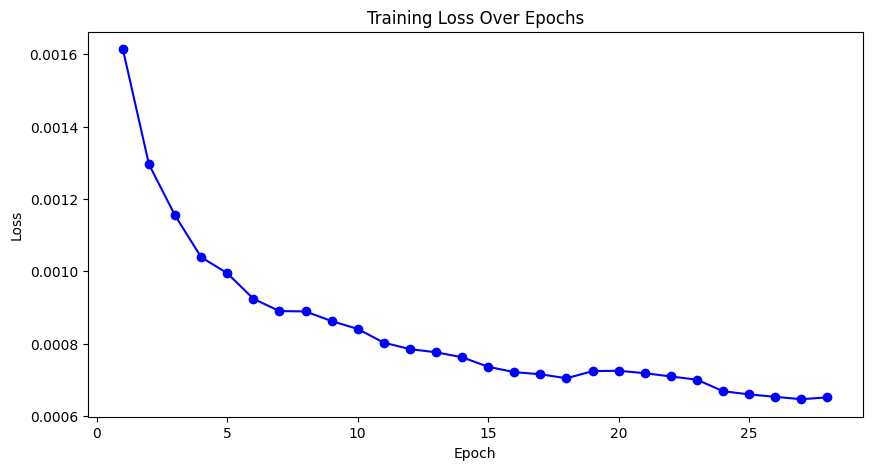

In [19]:
#Training loss plot
# Load the latest checkpoint
ckpt = '/srv/scratch/z5512000/weights/full/pdwhourglassepoch28.pth'
checkpoint = torch.load(ckpt)
epoch_losses = checkpoint['epoch_losses']

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', linestyle='-', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.grid(True)
plt.show()


In [24]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming hg_stack2 is your model class and it has been defined
# from your_model_file import hg_stack2  # Replace with your actual model import if necessary
device = torch.device('cuda:0')
# Create and load your model
model = hg_stack2().to(device)

# Initialize the optimizer and learning rate scheduler
optimizer = Adam(model.parameters(), lr=2.5e-4)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

# Load the checkpoint
ckpt = '/srv/scratch/z5512000/weights/full/pdwhourglassepoch40.pth'
checkpoint = torch.load(ckpt)

# Load the state dictionary of the model, optimizer, and learning rate scheduler
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optim'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])

# Print the current learning rate
current_lr = lr_scheduler.get_last_lr()
print(f"Current learning rate(s): {current_lr}")


Current learning rate(s): [0.00025]


In [ ]:
#Validation loss calculation and plot
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Assuming JointsMSELoss and MPIIDataset are already defined as provided above
# from your_model_file import YourModel  # Replace with your actual model import if necessary

# Setup the device for GPU/CPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Load your validation dataset
# validation_dataset = MPIIDataset(is_train=False)
# validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=6, pin_memory=True)

# Initialize the loss function
# loss_function = JointsMSELoss(use_target_weight=True).to(device)
criteon = JointsMSELoss().to(device)
target_weight = np.array([[1.2, 1.1, 1., 1., 1.1, 1.2, 1., 1.,
                           1., 1., 1.2, 1.1, 1., 1., 1.1, 1.2]])
target_weight = torch.from_numpy(target_weight).to(device).float()


# Path to your saved models
model_path = '/srv/scratch/z5512000/weights/full/pdwhourglassepoch{}.pth'
epochs = range(1, 41)  # Adjust this if you have more or fewer epochs
errors = []

# Evaluate each saved model
for epoch in epochs:
    model = hg_stack2().to(device)  
    # model.load_state_dict(torch.load(model_path.format(epoch)))
    checkpoint = torch.load(model_path.format(epoch))
    model.load_state_dict(checkpoint['model'])
    model.eval()

    total_mse_loss = 0
    count = 0

    with torch.no_grad():
        for img, heatmaps_gt, _ in validation_loader: 
            img, heatmaps_gt = img.to(device).float(), heatmaps_gt.to(device).float()
            heatmaps_pred = model(img)[-1]  # Get predictions from the last stack
            mse_loss = criteon(heatmaps_pred, heatmaps_gt, target_weight)
            total_mse_loss += mse_loss.item()
            count += 1


    average_loss = total_mse_loss / count
    errors.append(average_loss)
    print(f'Epoch {epoch}: Validation Loss = {average_loss:.10f}')
# Save the validation loss list to a file
with open('/srv/scratch/z5512000/weights/validation_losses.pkl', 'wb') as f:
    pickle.dump(errors, f)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(epochs, errors, marker='o', linestyle='-', color='orange')
plt.title('Validation Error by Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('MSE Loss')
# plt.grid(True)
plt.show()

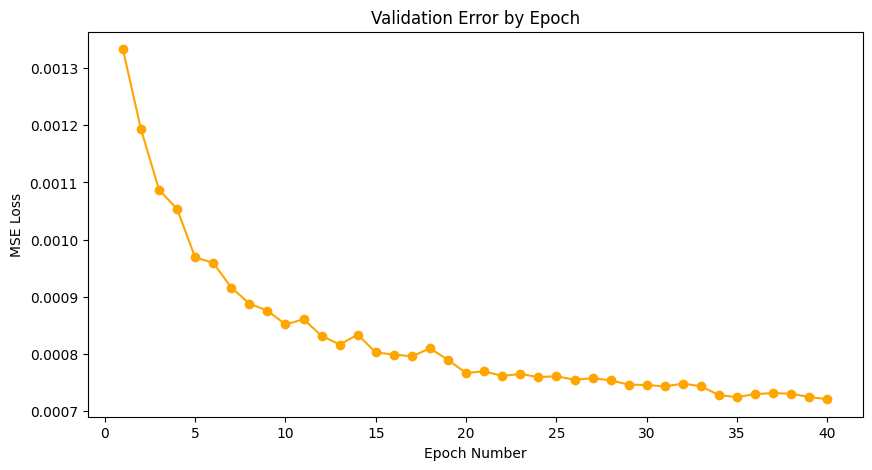

In [11]:
import pickle
# Save the validation loss list to a file
with open('/srv/scratch/z5512000/weights/validation_losses.pkl', 'wb') as f:
    pickle.dump(errors, f)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(epochs, errors, marker='o', linestyle='-', color='orange')
plt.title('Validation Error by Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('MSE Loss')
# plt.grid(True)
plt.show()

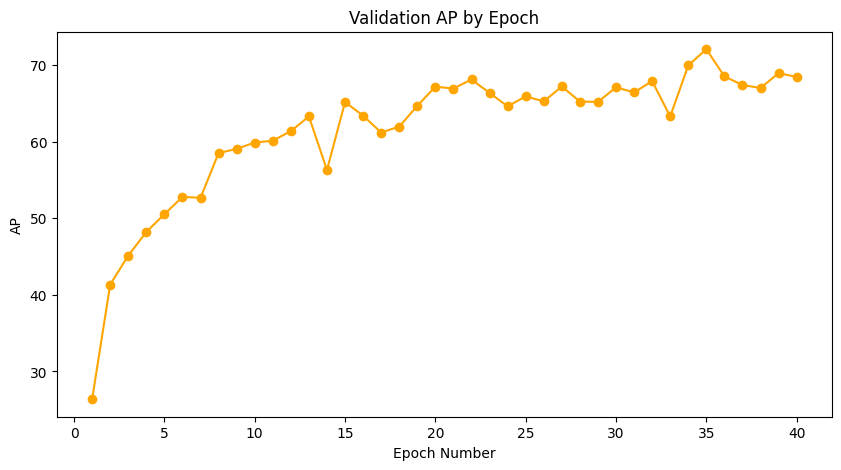

In [10]:
# Save the validation loss list to a file
with open('/srv/scratch/z5512000/weights/pcvalidation_ap.pkl', 'wb') as f:
    pickle.dump(aps, f)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(epochs, aps, marker='o', linestyle='-', color='orange')
plt.title('Validation AP by Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('AP')
# plt.grid(True)
plt.show()

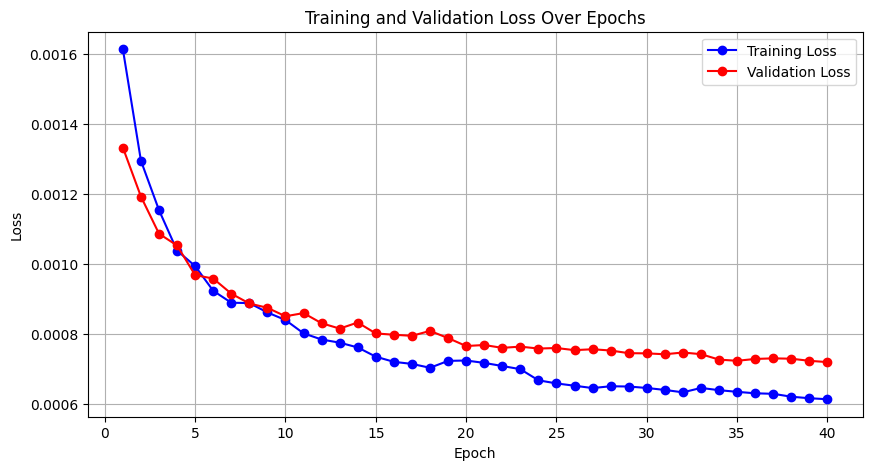

In [7]:
import torch
import pickle
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Load the training losses from the checkpoint file (assuming last epoch)
checkpoint_path = '/srv/scratch/z5512000/weights/full/pdwhourglassepoch40.pth'
checkpoint = torch.load(checkpoint_path)
training_losses = checkpoint['epoch_losses']

# Load the validation losses from the pickle file
pickle_file_path = '/srv/scratch/z5512000/weights/validation_losses.pkl'
with open(pickle_file_path, 'rb') as f:
    validation_losses = pickle.load(f)

# Ensure the lengths of training_losses and validation_losses are the same
assert len(training_losses) == len(validation_losses), "Mismatch in lengths of training and validation losses"

# Define the epochs range
epochs = range(1, len(training_losses) + 1)

# Plotting the training and validation losses
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(epochs, training_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
ax.plot(epochs, validation_losses, marker='o', linestyle='-', color='red', label='Validation Loss')
#plt.plot(epochs, validation_losses, marker='o', linestyle='-', color='orange', label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Adding a legend
plt.legend()
plt.grid(True)
# Display the plot
plt.show()
# Save the plot as a PDF
with PdfPages('mpiiloss.pdf') as pdf:
    pdf.savefig(fig)  # Save the specific figure
    plt.close(fig)  # Close the figure after saving

In [ ]:
#Till epoch 35
import torch
import pickle
import matplotlib.pyplot as plt

# Load the training losses from the checkpoint file (assuming last epoch)
checkpoint_path = '/srv/scratch/z5512000/weights/full/pdwhourglassepoch40.pth'
checkpoint = torch.load(checkpoint_path)
training_losses = checkpoint['epoch_losses']

# Load the validation losses from the pickle file
pickle_file_path = '/srv/scratch/z5512000/weights/validation_losses.pkl'
with open(pickle_file_path, 'rb') as f:
    validation_losses = pickle.load(f)

# Ensure the lengths of training_losses and validation_losses are the same
assert len(training_losses) == len(validation_losses), "Mismatch in lengths of training and validation losses"

# Define the epochs range
epochs = range(1, len(training_losses) + 1)

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.plot(epochs, validation_losses, marker='o', linestyle='-', color='red', label='Validation Loss')
#plt.plot(epochs, validation_losses, marker='o', linestyle='-', color='orange', label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


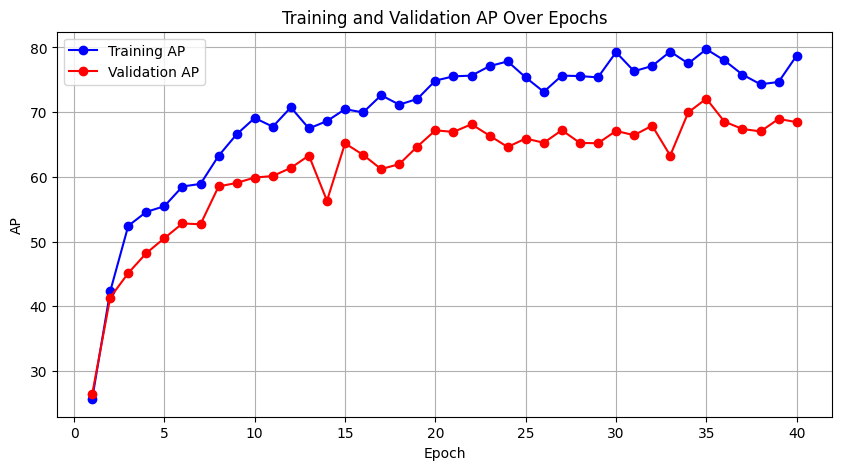

In [10]:
import matplotlib.pyplot as plt
import pickle
import torch

# Load the latest training checkpoint
ckpt = '/srv/scratch/z5512000/weights/full/appdwhourglassepoch40.pth'
checkpoint = torch.load(ckpt)
epoch_aps_training = checkpoint['epoch_aps']

# # Multiply each training PCKh value by 10
# epoch_pckhs_training_multiplied = [pckh * 10 for pckh in epoch_pckhs_training]

# Load the validation PCKh values
with open('/srv/scratch/z5512000/weights/pcvalidation_ap.pkl', 'rb') as f:
    epoch_aps_validation = pickle.load(f)

# # Divide each validation PCKh value by 10
# epoch_pckhs_validation_divided = [pckh / 10 for pckh in epoch_pckhs_validation]

# Plot both training and validation PCKh values on the same graph
fig, ax = plt.subplots(figsize=(10, 5))
epochs = range(1, len(epoch_aps_training) + 1)

ax.plot(epochs, epoch_aps_training, marker='o', linestyle='-', color='blue', label='Training AP')
ax.plot(epochs, epoch_aps_validation, marker='o', linestyle='-', color='red', label='Validation AP')

plt.title('Training and Validation AP Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AP')
plt.legend()
plt.grid(True)
plt.show()
with PdfPages('ap.pdf') as pdf:
    pdf.savefig(fig)  # Save the current figure using plt.gcf()
    plt.close()  # Close the figure after saving

In [8]:
import torch
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Load the pre-trained model
model_path = '/srv/scratch/z5512000/weights/full/pdwhourglassepoch40.pth'
model = hg_stack2().to(device)  # Ensure your model architecture is properly defined and matches the checkpoint
model.load_state_dict(torch.load(model_path)['model'])
model.eval()  # Set the model to evaluation mode

# Validation DataLoader setup (assuming validation_dataset is already defined)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=4)

# Initialize the loss function (assuming `target_weight` setup as previously defined)
criteon = JointsMSELoss().to(device)
target_weight = np.array([[1.2, 1.1, 1., 1., 1.1, 1.2, 1., 1.,
                           1., 1., 1.2, 1.1, 1., 1., 1.1, 1.2]])
target_weight = torch.from_numpy(target_weight).to(device).float()
# Calculate MSE on the validation set
total_mse_loss = 0
count = 0
with torch.no_grad():
    for img, heatmaps_gt, _ in validation_loader:  # Note the addition of "_" to handle additional data
        img, heatmaps_gt = img.to(device).float(), heatmaps_gt.to(device).float()
        heatmaps_pred = model(img)[-1]  # Get predictions from the last stack
        mse_loss = criteon(heatmaps_pred, heatmaps_gt, target_weight)
        total_mse_loss += mse_loss.item()
        count += 1

avg_mse_loss = total_mse_loss / count
print(f'Average MSE Loss on Validation Data: {avg_mse_loss}')


Average MSE Loss on Validation Data: 0.0007203282877280553


In [ ]:
import torch.onnx
# Create an instance of the model
model = hg_stack2()

# Create a dummy input that matches the input dimensions expected by the model
dummy_input = torch.randn(1, 3, 256, 256)
# Convert to ONNX format
torch.onnx.export(model, dummy_input, "model.onnx", verbose=True, input_names=['input'], output_names=['output'])

# Now you can open "model.onnx" in Netron
import netron

# Path to your model file
model_path = 'model.onnx'

# Start the Netron server
netron.start(model_path)


In [6]:
import numpy as np
from sklearn.metrics import auc
import torch

def calculate_precision_recall(y_true, y_pred, thresholds):
    precision = []
    recall = []
    for threshold in thresholds:
        tp = ((y_pred >= threshold) & (y_true == 1)).sum()
        fp = ((y_pred >= threshold) & (y_true == 0)).sum()
        fn = ((y_pred < threshold) & (y_true == 1)).sum()
        
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        precision.append(prec)
        recall.append(rec)
    return precision, recall

def average_precision(precision, recall):
    # Sort by recall
    sorted_indices = np.argsort(recall)
    sorted_recall = np.array(recall)[sorted_indices]
    sorted_precision = np.array(precision)[sorted_indices]
    
    # Calculate the area under the curve using the trapezoidal rule
    return auc(sorted_recall, sorted_precision)

def calculate_map_on_validation(validation_loader, model, device):
    model.eval()
    thresholds = np.linspace(0, 1, num=100)
    joint_precisions = [[] for _ in range(16)]  # Initialize lists to hold precision values for each joint
    joint_recalls = [[] for _ in range(16)]  # Initialize lists to hold recall values for each joint
    joints = ['left ankle', 'left knee', 'left hip', 'right hip', 'right knee', 'right ankle', 'belly', 'chest',
              'neck', 'head', 'left wrist', 'left elbow', 'left shoulder', 'right shoulder', 'right elbow', 'right wrist']

    with torch.no_grad():
        for img, heatmaps_gt, _ in validation_loader:
            img, heatmaps_gt = img.to(device).float(), heatmaps_gt.to(device).float()
            heatmaps_pred = model(img)[-1]  # Last stack predictions

            for i, joint in enumerate(joints):
                true_heatmap = heatmaps_gt[:, i, :, :].reshape(-1).cpu().numpy()
                pred_heatmap = heatmaps_pred[:, i, :, :].reshape(-1).cpu().numpy()

                precisions, recalls = calculate_precision_recall(true_heatmap, pred_heatmap, thresholds)
                
                # Accumulate precision and recall values across all images for each joint
                joint_precisions[i].extend(precisions)
                joint_recalls[i].extend(recalls)

    # Calculate AP for each joint across all images
    aps = []
    for i, joint in enumerate(joints):
        ap = average_precision(joint_precisions[i], joint_recalls[i])
        ap = ap*100
        aps.append(ap)
        print(f"AP for {joint}: {ap:.4f}")

    mAP = np.mean(aps)
    print(f"Average Precision across all joints, AP: {mAP:.4f}")
    # return mAP
    
    # # Plotting the results
    # plt.figure(figsize=(12, 6))
    # plt.bar(joints, aps, color='skyblue')
    # plt.xlabel('Joints')
    # plt.ylabel('Average Precision')
    # plt.title('Average Precision (AP) Across All Joints')
    # plt.xticks(rotation=45, ha='right')
    # plt.ylim(0, 100)  # Assuming AP values are between 0 and 1
    # plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.show()
    
    return mAP

#ep70-71.3; 60-70.6; 49-71.86
# Example usage:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = '/srv/scratch/z5512000/weights/full/pdwhourglassepoch35.pth'
model = hg_stack2().to(device)  # Ensure your model architecture is properly defined and matches the checkpoint
model.load_state_dict(torch.load(model_path)['model'])
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=6)
calculate_map_on_validation(validation_loader, model, device)


AP for left ankle: 54.0339
AP for left knee: 65.3378
AP for left hip: 67.6071
AP for right hip: 72.4811
AP for right knee: 66.2316
AP for right ankle: 65.8459
AP for belly: 81.2117
AP for chest: 89.1555
AP for neck: 84.8284
AP for head: 89.8751
AP for left wrist: 49.7869
AP for left elbow: 72.5644
AP for left shoulder: 80.6771
AP for right shoulder: 80.2784
AP for right elbow: 72.6155
AP for right wrist: 60.6425
Average Precision across all joints, AP: 72.0733


72.0733072328583

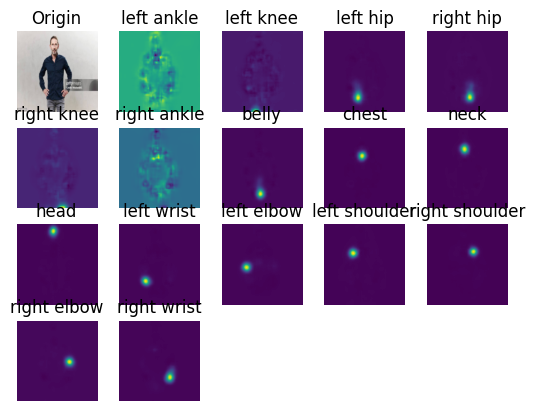

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


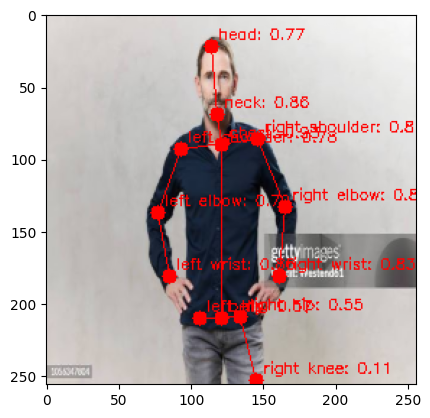

In [8]:
#Testing
%matplotlib inline
import torch

import matplotlib.pyplot as plt
import skimage

# from utils import draw_joints, load_image, show_heatmaps, heatmaps_to_coords
# from models.hourglass import hg_stack2
# from models.pose_res_net import PoseResNet
# from models.hr_net import hr_w32


use_model = 'Hourglass_Stack2' # Options：Hourglass_Stack2, ResNet, HRNet
ckpt = '/srv/scratch/z5512000/weights/full/pdwhourglassepoch40.pth' # model 
path_testimg = '/srv/scratch/z5512000/data/test_images/gettyimages-1056347804-612x612.jpg' # test image
# just ok - 060754485.jpg'  080839735.jpg 086310343.jpg

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


model = hg_stack2().to(device)
model.load_state_dict(torch.load(ckpt)['model'])
model.eval()

img_np = load_image(path_testimg)
img_np = skimage.transform.resize(img_np, [256,256])
img_np_copy = img_np
if img_np_copy.max() > 1.0:  # Assuming img_np_copy is the image array
    img_np_copy = img_np_copy / 255.0

img = torch.from_numpy(img_np).permute(2,0,1).unsqueeze(0).float().to(device)


heatmaps_pred = model(img)[-1]

# (1,c,h,w)
heatmaps_pred = heatmaps_pred.double()

heatmaps_pred_np = heatmaps_pred.squeeze(0).permute(1,2,0).detach().cpu().numpy()

show_heatmaps(img_np_copy, heatmaps_pred_np)

coord_joints = heatmaps_to_coords(heatmaps_pred_np, resolu_out=[256, 256], prob_threshold=0.1)
img_rgb = draw_joints(img_np_copy, coord_joints)
plt.imshow(img_rgb)
plt.show()
# print(coord_joints)

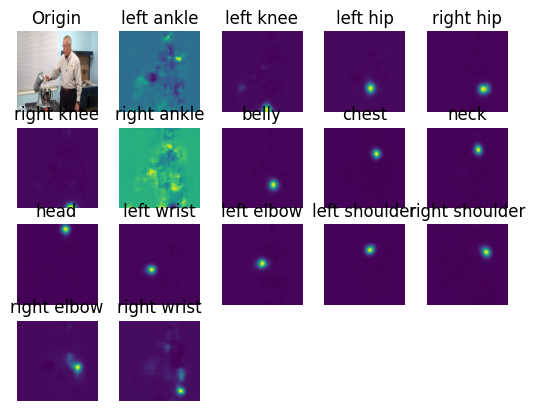

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


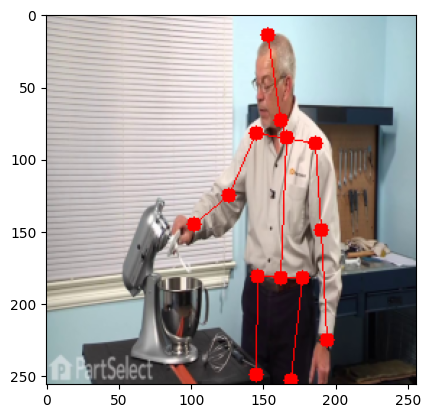

In [7]:
#Testing
%matplotlib inline
import torch

import matplotlib.pyplot as plt
import skimage

# from utils import draw_joints, load_image, show_heatmaps, heatmaps_to_coords
# from models.hourglass import hg_stack2
# from models.pose_res_net import PoseResNet
# from models.hr_net import hr_w32


use_model = 'Hourglass_Stack2' # Options：Hourglass_Stack2, ResNet, HRNet
ckpt = '/srv/scratch/z5512000/weights/full/pdwhourglassepoch40.pth' # model 
path_testimg = '/srv/scratch/z5512000/data/images/000187274.jpg' # test image
# just ok - 060754485.jpg'  080839735.jpg 086310343.jpg

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


model = hg_stack2().to(device)
model.load_state_dict(torch.load(ckpt)['model'])
model.eval()

img_np = load_image(path_testimg)
img_np = skimage.transform.resize(img_np, [256,256])
img_np_copy = img_np
if img_np_copy.max() > 1.0:  # Assuming img_np_copy is the image array
    img_np_copy = img_np_copy / 255.0

img = torch.from_numpy(img_np).permute(2,0,1).unsqueeze(0).float().to(device)


heatmaps_pred = model(img)[-1]

# (1,c,h,w)
heatmaps_pred = heatmaps_pred.double()

heatmaps_pred_np = heatmaps_pred.squeeze(0).permute(1,2,0).detach().cpu().numpy()

show_heatmaps(img_np_copy, heatmaps_pred_np)

coord_joints = heatmaps_to_coords(heatmaps_pred_np, resolu_out=[256, 256], prob_threshold=0.1)
img_rgb = draw_joints(img_np_copy, coord_joints)
plt.imshow(img_rgb)
plt.show()
# print(coord_joints)

